<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/ARIMA_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroup_Test_B%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using ARIMA Model based on Patient Visits Medical Laboratory Data (GroupTestB)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn

     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 9.5MB 20.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 6.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=542066643b98596bcc43ce13252de3641d8011af7b2a1e2b1e4b4322d233539a
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 65kB/s 
     |████████████████████████████████| 901kB 31.2MB/s 
     |████████████████████████████████| 10.1MB 32.0MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 5.4MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [4]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [6]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data['weekday']= data.apply(lambda row: row['date'].weekday(),axis=1)
data['weekday'] = (data["weekday"] < 5).astype(int)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1348 non-null   datetime64[ns]
 1   hm        1348 non-null   int64         
 2   hm_aw     1348 non-null   int64         
 3   hm_am     1348 non-null   int64         
 4   cc        1348 non-null   int64         
 5   cc_aw     1348 non-null   int64         
 6   cc_am     1348 non-null   int64         
 7   day_week  1348 non-null   int64         
 8   weekday   1348 non-null   int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 94.9 KB


In [8]:
data.head(5)

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1


## **Step#2 Data Processing**

### **Picking Variable**

In [11]:
df = data.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [12]:
cc = df['cc'].fillna(df['cc'].mean())
cc_aw = df['cc_aw'].fillna(df['cc'].mean())
cc_am = df['cc_am'].fillna(df['cc'].mean())
weekday = df['weekday'].fillna(df['cc'].mean())

In [13]:
df_cc = pd.DataFrame({'cc':cc, 'cc_aw':cc_aw, 'cc_am':cc_am, 'weekday':weekday})
df.to_csv("cc.csv")
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cc       1348 non-null   int64
 1   cc_aw    1348 non-null   int64
 2   cc_am    1348 non-null   int64
 3   weekday  1348 non-null   int64
dtypes: int64(4)
memory usage: 42.2 KB


In [14]:
df_cc.head()

,cc,cc_aw,cc_am,weekday
0,44,37,45,0
1,72,37,43,0
2,87,42,44,1
3,58,49,44,1
4,72,53,44,1


### **Stationary Test**

In [17]:
result1 = adfuller(df_cc['cc'].dropna())
result2 = adfuller(df_cc['cc_aw'].dropna())
result3 = adfuller(df_cc['cc_am'].dropna())
result4 = adfuller(df_cc['weekday'].dropna())

print("cc")
print("ADF Statistics",result1[0])
print("p-value",result1[1])
print("critical values",result1[5])
if result1[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("cc_aw")   
print("ADF Statistics",result2[0])
print("p-value",result2[1])
print("critical values",result2[5])
if result2[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("cc_am")   
print("ADF Statistics",result3[0])
print("p-value",result3[1])
print("critical values",result2[5])
if result3[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("weekday")   
print("ADF Statistics",result4[0])
print("p-value",result4[1])
print("critical values",result2[5])
if result3[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

cc
ADF Statistics -3.0290163967406745
p-value 0.032272058590179856
critical values 10246.913031783473
fail to reject null hypothese h1 , it mean data is stationary
cc_aw
ADF Statistics -2.7540068340092305
p-value 0.06514981700918167
critical values 5296.1453120549095
Reject the null hypotheise , it mean data is not stationary
cc_am
ADF Statistics -2.95066276026426
p-value 0.03976586748398463
critical values 5296.1453120549095
fail to reject null hypothese h1 , it mean data is stationary
weekday
ADF Statistics 3.2073789182702655e-12
p-value 0.9585320860603213
critical values 5296.1453120549095
fail to reject null hypothese h1 , it mean data is stationary


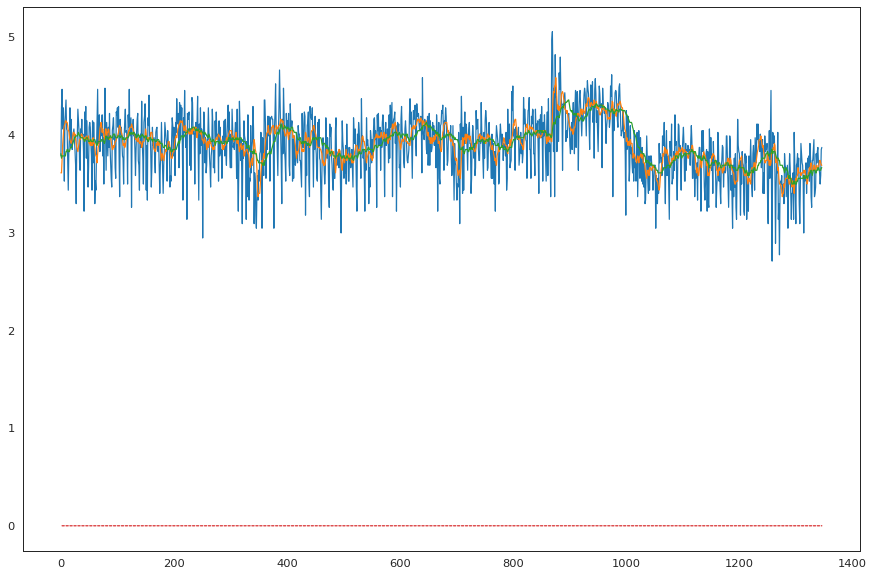

In [20]:
rcParams['figure.figsize'] = 15,10
#Estimate trend
df_cc_logScale = np.log(df_cc)
plt.plot(df_cc_logScale)

### **Differencing**

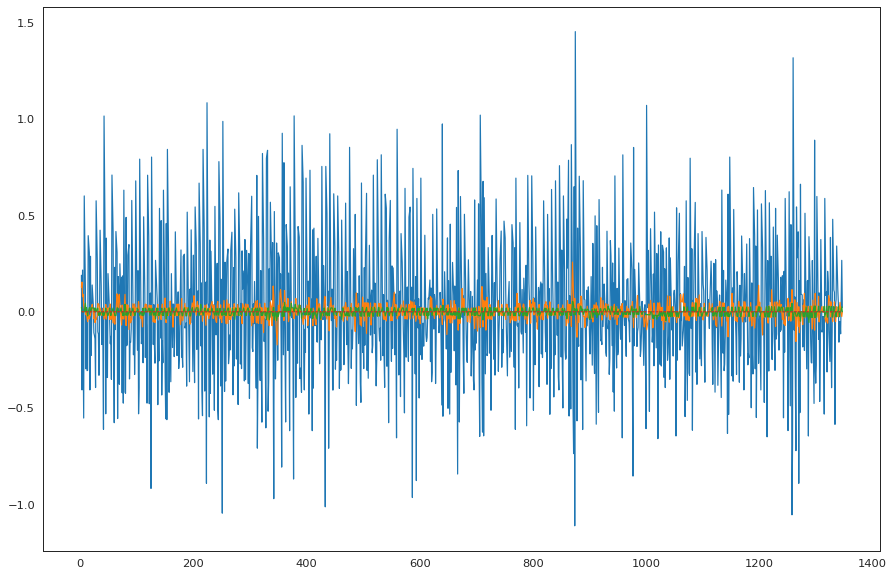

In [21]:
dfLogDiff = df_cc_logScale-df_cc_logScale.shift()
dfLogDiff.dropna(inplace=True)
plt.plot(dfLogDiff)

In [22]:
result1 = adfuller(dfLogDiff['cc'].dropna())
result2 = adfuller(dfLogDiff['cc_aw'].dropna())
result3 = adfuller(dfLogDiff['cc_am'].dropna())

print("cc")
print("ADF Statistics",result1[0])
print("p-value",result1[1])
print("critical values",result1[5])
if result1[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("cc_aw")   
print("ADF Statistics",result2[0])
print("p-value",result2[1])
print("critical values",result2[5])
if result2[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("cc_am")   
print("ADF Statistics",result3[0])
print("p-value",result3[1])
print("critical values",result2[5])
if result3[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

cc
ADF Statistics -7.699436860019977
p-value 1.3516300564973485e-11
critical values 162.5536883689947
fail to reject null hypothese h1 , it mean data is stationary
cc_aw
ADF Statistics -8.987040238812346
p-value 7.055137726253461e-15
critical values -4295.790845984822
fail to reject null hypothese h1 , it mean data is stationary
cc_am
ADF Statistics -6.570591881831669
p-value 7.954451436630963e-09
critical values -4295.790845984822
fail to reject null hypothese h1 , it mean data is stationary


### **Autocorrelation, ACF and PACF Plots**

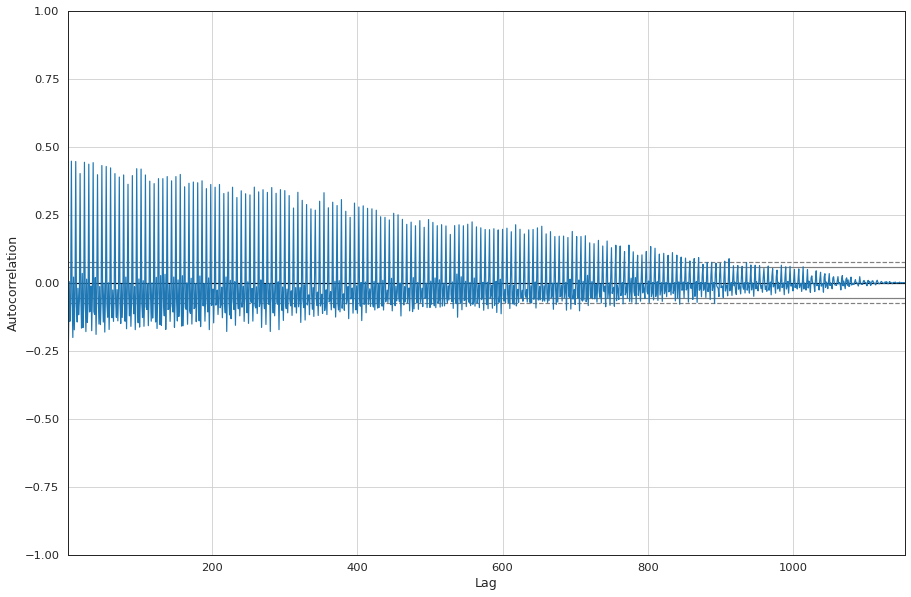

In [23]:
# from pandas.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

acf_pcf = dfLogDiff['cc'].astype(float)
autocorrelation_plot(acf_pcf)

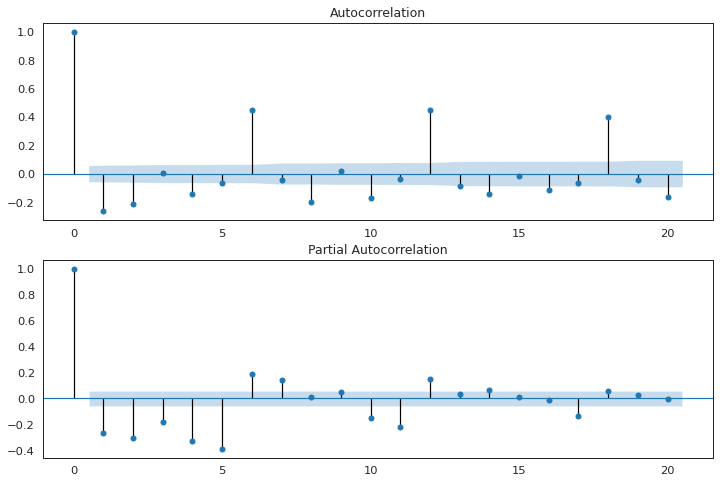

In [24]:
#2 plots on one sheet

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(acf_pcf, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(acf_pcf, lags=20, ax=ax2)

#blue color means the boundaries of the 95% confidence interval
#if bar ranges outside the boundaries, we can assume that the lag has autocorrelation

## **Step#3 Fitting and Training Model**

Text(0.5, 1.0, 'RSS: nan')

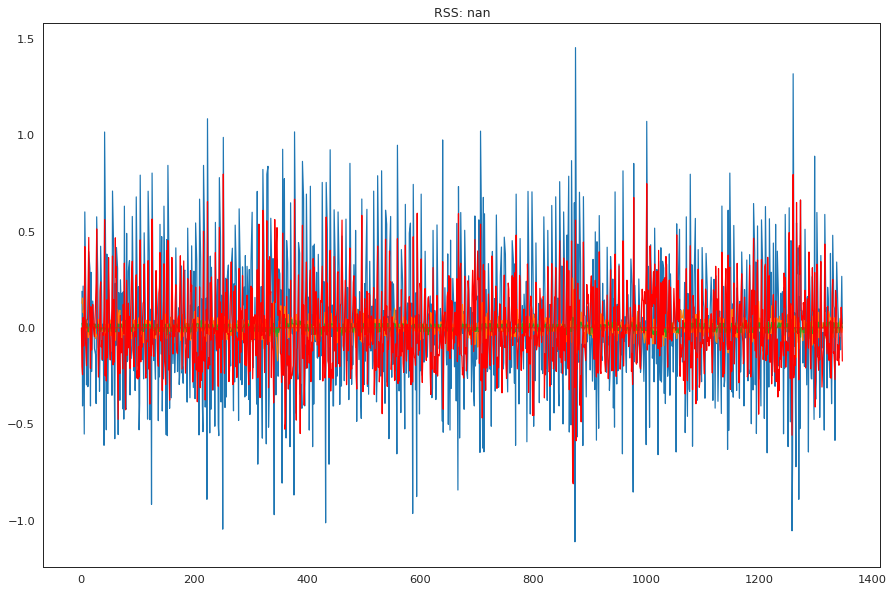

In [25]:
from statsmodels.tsa.arima_model import ARIMA
# Model Order
model = ARIMA(df_cc_logScale['cc'],order=(1, 1, 1))

# Show Result
result_ARIMA= model.fit(disp=-1)
plt.plot(dfLogDiff)
plt.plot(result_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((result_ARIMA.fittedvalues-dfLogDiff['cc'])**2))

In [26]:
pred_ARIMA = pd.Series(result_ARIMA.fittedvalues,copy=True)
print(pred_ARIMA.head())

1   -0.0003
2   -0.2025
3   -0.2433
4    0.0531
5   -0.0943
dtype: float64


In [27]:
pred_ARIMA_cumsum = pred_ARIMA.cumsum()
print(pred_ARIMA_cumsum.head())

1   -0.0003
2   -0.2027
3   -0.4461
4   -0.3930
5   -0.4873
dtype: float64


In [28]:
prediction_ARIMA_log = pd.Series(df_cc_logScale['cc'].iloc[0], index=df_cc_logScale.index)
prediction_ARIMA_log = prediction_ARIMA_log.add(pred_ARIMA_cumsum,fill_value =0)
prediction_ARIMA_log.head()

0   3.7842
1   3.7839
2   3.5814
3   3.3381
4   3.3912
dtype: float64

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

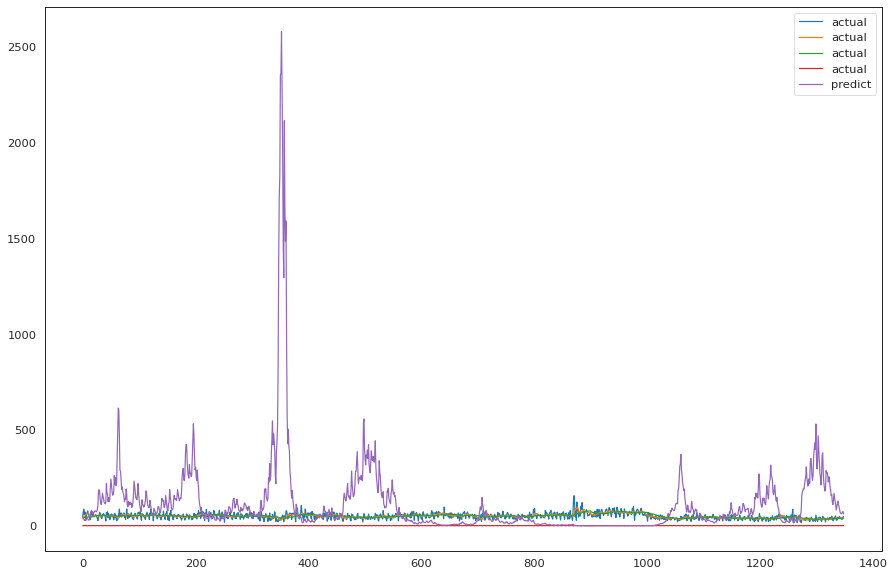

In [29]:
prediction_ARIMA = np.exp(prediction_ARIMA_log)
plt.plot(df_cc, label='actual')
plt.plot(prediction_ARIMA, label='predict')
plt.legend(loc='best')

In [31]:
# MSE and RMSE Score
print('MSE value :', mean_squared_error(cc, prediction_ARIMA))
print('RMSE value  : ', sqrt(mean_squared_error(cc, prediction_ARIMA)))

MSE value : 50886.27825586066
RMSE value  :  225.57987112298088
